In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt                                                       
from matplotlib import cm
import matplotlib.animation as animation
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import ezgal # BC03 model maker
import os
from astropy.cosmology import LambdaCDM
import pandas as pd

In [2]:
# check to make sure we have defined the bpz filter path
if not os.getenv('EZGAL_FILTERS'):
    os.environ['EZGAL_FILTERS'] = (f'{os.environ["HOME"]}/Projects/planckClusters/MOSAICpipe/bpz-1.99.3/FILTER/')


In [3]:
#model2 = ezgal.model('/home/boada/Projects/BC2003/bc03/newiseds/1_0gyr_hr_m62_salp.ised')
model2 = ezgal.model('bc03_ssp_z_0.02_salp.model')
model2 = model2.make_exponential(1)
#model2 = ezgal.model('bc03_exp_1.0_z_0.02_salp.model')
model2.set_cosmology(Om=0.3, Ol=0.7, h=0.7, w=-1)

/home/boada/.local/lib/python3.6/site-packages/ezgal/data/models/bc03_ssp_z_0.02_salp.model


/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:358: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:360: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:361: RuntimeWarning: invalid value encountered in add
  y[slice2]*(2-h0divh1))


True

In [4]:
model2.add_filter('g_MOSAICII.res', name='g')
model2.add_filter('r_MOSAICII.res', name='r')
model2.add_filter('i_MOSAICII.res', name='i')
model2.add_filter('z_MOSAICII.res', name='z')
model2.add_filter('K_KittPeak.res', name='K')

In [5]:
Mr_star = -20.44 + 5 * np.log10(0.7) # abs mag.
# set the normalization
model2.set_normalization('sloan_r', 0.1, Mr_star, vega=False)

In [6]:
# desired formation redshift
zf = 6.0
# fetch an array of redshifts out to given formation redshift
zs = model2.get_zs( zf )

In [7]:
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7, Tcmb0=2.725)
dlum = cosmo.luminosity_distance(zs)

h = cosmo.H0.value/100

# Calculate some cosmological stuff
DM = cosmo.distmod(zs)
dlum = cosmo.luminosity_distance(zs)

In [14]:
mlim = 24
mlim - cosmo.distmod(0.4).value - model2.get_kcorrects(zf, filters='i', zs=0.4)

-18.01828907152557

In [13]:
zs

array([5.000e-03, 1.000e-02, 1.500e-02, 2.000e-02, 2.500e-02, 3.000e-02,
       3.500e-02, 4.000e-02, 4.500e-02, 5.000e-02, 5.500e-02, 6.000e-02,
       6.500e-02, 7.000e-02, 7.500e-02, 8.000e-02, 8.500e-02, 9.000e-02,
       9.500e-02, 1.000e-01, 1.250e-01, 1.500e-01, 1.750e-01, 2.000e-01,
       2.250e-01, 2.500e-01, 2.750e-01, 3.000e-01, 3.250e-01, 3.500e-01,
       3.750e-01, 4.000e-01, 4.250e-01, 4.500e-01, 4.750e-01, 5.000e-01,
       5.250e-01, 5.500e-01, 5.750e-01, 6.000e-01, 6.250e-01, 6.500e-01,
       6.750e-01, 7.000e-01, 7.250e-01, 7.500e-01, 7.750e-01, 8.000e-01,
       8.250e-01, 8.500e-01, 8.750e-01, 9.000e-01, 9.250e-01, 9.500e-01,
       9.750e-01, 1.000e+00, 1.025e+00, 1.050e+00, 1.075e+00, 1.100e+00,
       1.125e+00, 1.150e+00, 1.175e+00, 1.200e+00, 1.225e+00, 1.250e+00,
       1.275e+00, 1.300e+00, 1.325e+00, 1.350e+00, 1.375e+00, 1.400e+00,
       1.425e+00, 1.450e+00, 1.475e+00, 1.500e+00, 1.525e+00, 1.550e+00,
       1.575e+00, 1.600e+00, 1.625e+00, 1.650e+00, 

In [8]:
filter = 'sloan_g'
Mstar = model2.get_absolute_mags(zf, filters=filter, zs=0.1)

mstar = (Mstar + DM.value + model2.get_kcorrects(zf, filters=filter, zs=zs) +
      model2.get_ecorrects(zf, filters=filter, zs=zs) -
      model2.get_ecorrects(zf, filters=filter, zs=0.1))

LBCG = 4.0
mstar_sub = mstar - 2.5 * np.log10(0.4)                                 
BCG = mstar - 2.5 * np.log10(LBCG)

/home/boada/.local/lib/python3.6/site-packages/ezgal/cosmology.py:185: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)


In [ ]:
plt.plot(zs, mstar_sub, 'k-', linewidth=0.5, label='$0.4L_\star$ galaxy')
plt.plot(zs, mstar, 'k-', linewidth=1.5, label='$L_\star$ galaxy')
plt.plot(zs, BCG, 'k-', linewidth=2.5, label='$%dL_\star$ (BCG)' % LBCG)
plt.xlabel('Redshift')
plt.xlim(0,2)

In [9]:
Mr_star

-21.214509799928717

In [10]:
model2.get_kcorrects(zf, filters='g', zs=0.10145)

0.35042645434867215

In [11]:
model2.get_kcorrects(zf, filters='sloan_g', zs=0.10145)

0.3550852878041928

In [12]:
mags = [model2.get_apparent_mags(zf, filters=i, zs=zs) for i in 'grizK']

<IPython.core.display.Javascript object>


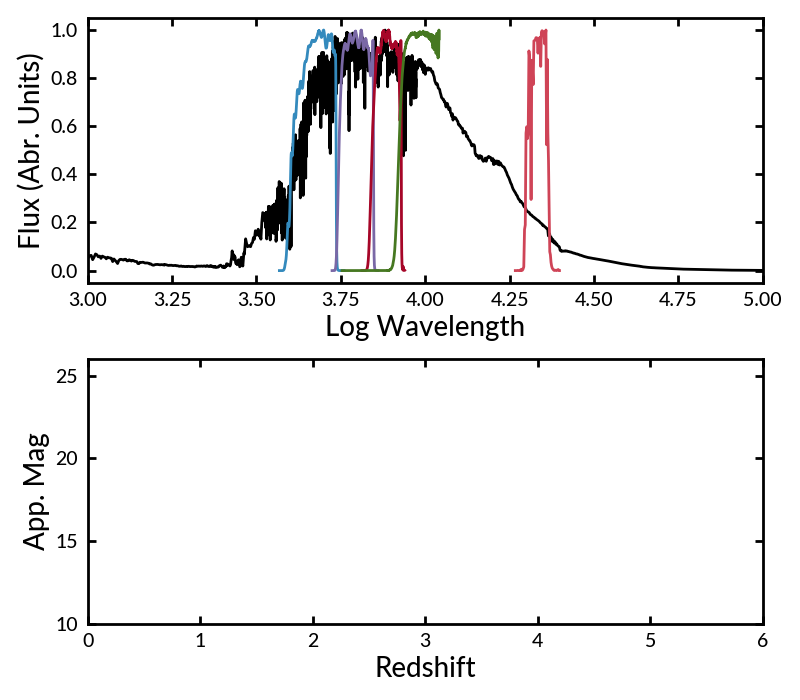

In [13]:
def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    return line,

def animate(i):
    ls, sed = model2.get_sed_z(zf, zs[i], units='Fl', return_frequencies=True, observed=True, normalize=True )
    # normalize for plotting
    sed /= sed.max()
    # update the data.
    line.set_xdata(np.log10(ls))
    line.set_ydata(sed) 
        
    line2.set_data(zs[:i], mags[0][:i])
    line3.set_data(zs[:i], mags[1][:i])
    line4.set_data(zs[:i], mags[2][:i])
    line5.set_data(zs[:i], mags[3][:i])
    line6.set_data(zs[:i], mags[4][:i])
    
    time_text.set_text(time_template % (zs[i]))
    return line, line2, time_text

# make a figure
fig, axes = plt.subplots(2, 1, squeeze=True, figsize=(8,7))
ax = axes[0]
ax2 = axes[1]

# do some initial plotting
ls, sed = model2.get_sed_z(zf, 0.01, units='Fl', return_frequencies=True, observed=True, normalize=True )
# normalize first
sed /= sed.max()
line, = ax.plot(np.log10(ls), sed, 'k-')
line2, = ax2.plot([], [],)
line3, = ax2.plot([], [],)
line4, = ax2.plot([], [],)
line5, = ax2.plot([], [],)
line6, = ax2.plot([], [],)

# plot the filters
for f in [i for i in 'grizK']:
    normed_trans = model2.filters[f].tran_ls/model2.filters[f].tran_ls.max()
    ax.plot(np.log10(model2.filters[f].ls), normed_trans)

time_template = 'z = %.3f'    # prints running simulation time
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
ax.set_xlim(3, 5)
ax2.set_xlim(0, zf)
ax2.set_ylim(10, 26)

ax.set_ylabel('Flux (Abr. Units)')
ax.set_xlabel('Log Wavelength')
ax2.set_ylabel('App. Mag')
ax2.set_xlabel('Redshift')


ani = animation.FuncAnimation(
    fig, animate, init_func=init, blit=True, frames=range(len(zs)), interval=200)
plt.tight_layout()
plt.show()
#ani.save('./animation.gif', writer='imagemagick', fps=6)


In [ ]:
t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])

animate = lambda i: l.set_data(t[:i], x[:i])

ani = animation.FuncAnimation(fig, animate, frames=len(t))

plt.show()